In [37]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup

# Import a utility to download and load example data
from fooof.utils.download import load_fooof_data

import mne
import numpy as np
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from spiketools.plts.utils import make_axes
from math import floor
import random
from scipy import stats

import imagesc as imagesc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup
from fooof.utils.params import compute_knee_frequency

# Import a utility to download and load example data
from fooof.utils.download import load_fooof_data
from pathlib import Path
import glob


# Import custom project code
import sys
sys.path.append("/home/b1044271/Columbia/Aperiodic_sleep/Aperiodic_sleep_paper/helpers")
from utils import check_distribution, perform_correlation, compute_z_values, compute_cliffs_delta, bonferroni_correction, friedman_dunns

In [4]:
# get all Sleep staging files
staging_files = '/home/b1044271/EEGsleep/SleepStaging/*.txt'
stage_files = glob.glob(staging_files)

# get all FOOOF parameters files
path_files = '/home/b1044271/Columbia/Results/Time-resolved/E257/*.npy'
aperiodic_files = glob.glob(path_files)

In [5]:
# Adjust sampling rate of sleep stages
def resample_stages(path_file, new_samp_rate):
    stage_file = pd.read_csv(path_file)
    #set required time resolution - stages are in 30 seconds so the conversion depends on the time resolution specified
    cov_eq = 30/new_samp_rate
    stages = list(stage_file.iloc[:,0])
    stages_n = [val for val in stages for _ in range(0, floor(cov_eq))]
    return(stages_n)

sfiles = np.zeros([17,50000])*np.nan
i=0
for X in stage_files:
    x  = resample_stages(X, 2)
    sfiles[i,0:len(x)] = x
    i=i+1

# 30s epochs

## Ignore this part of you have already run FOOOF and saved the results

In [6]:
# get the staging list
path_stage = Path('/home/b1044271/EEGsleep/SleepStaging/mat/mne2/')
stage_files = os.listdir(path_stage)
stage_files = [file for file in stage_files]
stage_files = sorted(stage_files)

# get the subjects list
Data_path = '/home/b1044271/Columbia/Preprocessed/Better_ica/'
subj_files = os.listdir(Data_path)
subj_files = [file for file in subj_files]
subj_files = sorted(subj_files)

# Create path for results
path_results = Path('/home/b1044271/Columbia/Results/Time-resolved/ALL_electrodes/')

# Don not run the following 

In [7]:
# select electrodes (if empty, uses all electrodes)
electrode = 'E257'

# Set parameters for calculating
t     = 15 #in seconds
f_min =  1 # maximum frequency
f_max =  45 # maximum frequency
fs    = 250 #sampling freq

# Settings for the frequency calculations (Welch's method)
SETTINGS_B  = { 'method' : 'welch', 'average' : 'mean', 'fmin' :f_min , 'fmax':f_max, 'n_fft': fs*t}

# FOOF settings
SETTINGS_F1={'max_n_peaks':8, 'aperiodic_mode':'fixed'}
SETTINGS_F2={'max_n_peaks':8, 'aperiodic_mode':'knee'}

# Helper function for paths
def check_path(path):
    if not os.path.exists(path):
        os.mkdir(path)

# Vectors for storing results per subject
Slope_nk = np.zeros([5,17,1000])* np.nan
Slope_k = np.zeros([5,17,1000])* np.nan

Knee_k = np.zeros([5,17,1000])* np.nan

Slope_k_fullnight = np.zeros([17,10000])* np.nan
Slope_nk_fullnight = np.zeros([17,10000])* np.nan

Knee_k_fullnight = np.zeros([17,10000])* np.nan

# START
i= 0
for S in subj_files:
    EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, S)) # read raw .set file
    print('loaded')
      
    EEG = EEG.pick(electrode, exclude=[]) # select Cz for further analysis
    events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers
    epochs = mne.Epochs(EEG, events=events, tmin=-30, tmax=0)
    
    # The whole night
    ALL_psd = epochs.compute_psd(**SETTINGS_B) #N1
    
    fm1 = FOOOFGroup(**SETTINGS_F1)
    fm2 = FOOOFGroup(**SETTINGS_F2)

    fm1.fit(ALL_psd._freqs, np.squeeze(ALL_psd._data), [ALL_psd._freqs[0] , ALL_psd._freqs[-1]])
    fm1.save(S[0:4] + 'ALLNight_NK',  file_path = path_results / S[0:4], save_results=True)

    fm2.fit(ALL_psd._freqs, np.squeeze(ALL_psd._data), [ALL_psd._freqs[0] , ALL_psd._freqs[-1]])
    fm2.save(S[0:4] + 'ALLNight_K',  file_path = path_results / S[0:4], save_results=True)
    
    
    Slope_nk_fullnight[i, 0:len(fm1.get_params('aperiodic_params','exponent'))] = fm1.get_params('aperiodic_params','exponent')
    Slope_k_fullnight[i, 0:len(fm2.get_params('aperiodic_params','exponent'))] = fm2.get_params('aperiodic_params','exponent')
    Knee_k_fullnight[i, 0:len(fm2.get_params('aperiodic_params','knee'))] = fm2.get_params('aperiodic_params','knee')
             
    
# Frequency transformation welch's method from 1 to 70Hz different time stamps
    #Now we select epochs and average over all epochs
    N1s = epochs['1']
    N2s = epochs['2']
    N3s = epochs['3']
    RMs = epochs['5']
    AWs = epochs['0']

   # Settings for PSD calculation using welch's
    N1={}
    N2={}
    N3={}
    AW={}
    RM={}
    
    # Calculate PSD per stage
    N1_psd = N1s.compute_psd(**SETTINGS_B) #N1
    N2_psd = N2s.compute_psd(**SETTINGS_B) #N2
    N3_psd = N3s.compute_psd(**SETTINGS_B)
    AW_psd = AWs.compute_psd(**SETTINGS_B)
    RM_psd = RMs.compute_psd(**SETTINGS_B)

    
    stages = [N1_psd, N2_psd, N3_psd, AW_psd, RM_psd]
    names_NK  = ['_NK_N1_30s', '_NK_N2_30s', '_NK_N3_30s', '_NK_AW_30s', '_NK_RM_30s']
    names_K  = ['_K_N1_30s', '_K_N2_30s', '_K_N3_30s', '_K_AW_30s', '_K_RM_30s']
   
    ix=0
    for X in stages:
    
    # FOOFGroup to add paramters from all channels
        #fm1 = FOOOFGroup(**SETTINGS_F1)
        fm2 = FOOOFGroup(**SETTINGS_F2)

        #fm1.fit(X._freqs, np.squeeze(X._data), [X._freqs[0] , X._freqs[-1]])
        #fm1.save(S[0:4] + names_NK[ix],  file_path = path_results / S[0:4], save_results=True)

        fm2.fit(X._freqs, np.squeeze(X._data), [X._freqs[0] , X._freqs[-1]])
        fm2.save(S[0:4] + names_K[ix],  file_path = path_results / S[0:4], save_results=True)
    
        #Slope_nk[ix,i, 0:len(fm1.get_params('aperiodic_params','exponent'))] = fm1.get_params('aperiodic_params','exponent')
        #Slope_k[ix,i, 0:len(fm2.get_params('aperiodic_params','exponent'))] = fm2.get_params('aperiodic_params','exponent')
        Knee_k[ix,i, 0:len(fm2.get_params('aperiodic_params','knee'))] = fm2.get_params('aperiodic_params','knee')
        
        # loop over stages 
        ix=ix+1
    #loop over subjects
    i = i+1


KeyboardInterrupt: 

In [ ]:
# saving the results in numpy files
#np.save(str(path_results) +  '/'  + 'Slope_nk_mean_30s',Slope_nk)
#np.save(str(path_results) +  '/'  + 'Slope_k_mean_30s',Slope_k)
#np.save(str(path_results) +  '/'  + 'r2_k_mean_30s',r2_k)
#np.save(str(path_results) +  '/'  + 'r2_nk_mean_30s',r2_nk)
#np.save(str(path_results) +  '/'  + 'Knee_k_mean_30s',Knee_k)
#np.save(str(path_results) +  '/'  + 'Offset_nk_mean_30s',Off_nk)
#np.save(str(path_results) +  '/'  + 'Offset_k_mean_30s',Off_k)
#np.save(str(path_results) +  '/'  + 'Error_nk_mean_30s',E_nk)
#np.save(str(path_results) +  '/'  + 'Error_k_mean_30s',E_k)

np.save(str(path_results) +  '/'  + 'Slope_nk_fullnight_30s',Slope_nk_fullnight)
np.save(str(path_results) +  '/'  + 'Slope_k_fullnight_30s',Slope_k_fullnight)
np.save(str(path_results) +  '/'  + 'Knee_fullnight_30s',Knee_k_fullnight)
np.save(str(path_results) +  '/'  + 'Knee_mean_30s',Knee_k)

## Start here to load saved data

In [53]:
# Create path for results
path_results = Path('/home/b1044271/Columbia/Results/Time-resolved/ALL_electrodes/')

#load
Slope_nk = np.load((str(path_results) +  '/'  + 'Slope_nk_mean_30s.npy'))
Slope_k = np.load((str(path_results) +  '/'  + 'Slope_k_mean_30s.npy'))

Knee_Fullnight = np.load((str(path_results) +  '/'  + 'Knee_fullnight_30s.npy'))
Knee_k = np.load((str(path_results) +  '/'  + 'Knee_mean_30s.npy'))

# Use the appropriate model
N1expk = Slope_k[0,:,:]
N2expk = Slope_k[1,:,:]
N3expk = Slope_k[2,:,:]
RMexpk = Slope_k[4,:,:]
WKexpk = Slope_k[3,:,:]

N1expnk = Slope_nk[0,:,:]
N2expnk = Slope_nk[1,:,:]
N3expnk = Slope_nk[2,:,:]
RMexpnk = Slope_nk[4,:,:]
WKexpnk = Slope_nk[3,:,:]

N1knee = Knee_k[0,:,:]
N2knee = Knee_k[1,:,:]
N3knee = Knee_k[2,:,:]
RMknee = Knee_k[4,:,:]
WKknee = Knee_k[3,:,:]

# Next cell only if knee freq is used


In [23]:
# Get Knee Freq from Knee value
N1kf = compute_knee_frequency(N1expk, N1knee)
N2kf = compute_knee_frequency(N2expk, N2knee)
N3kf = compute_knee_frequency(N3expk, N3knee)
RMkf = compute_knee_frequency(RMexpk, RMknee)
WKkf = compute_knee_frequency(WKexpk, WKknee)

N1exp = np.zeros([17,1000])*np.nan
N2exp = np.zeros([17,1000])*np.nan
N3exp = np.zeros([17,1000])*np.nan
RMexp = np.zeros([17,1000])*np.nan
WKexp = np.zeros([17,1000])*np.nan

for i in np.arange(17):
    for ii in np.arange(1000):
        if N1kf[i,ii] < 1 or N1kf[i,ii] > 45:
                N1exp[i,ii] = np.nan
        else:
                N1exp[i,ii] = N1kf[i,ii]   
        
        if N2kf[i,ii] < 1 or N2kf[i,ii] > 45:
                N2exp[i,ii] = np.nan
        else:
                N2exp[i,ii] = N2kf[i,ii] 
                
        if N3kf[i,ii] < 1 or N3kf[i,ii] > 45:
                N3exp[i,ii] = np.nan
        else:
                N3exp[i,ii] = N3kf[i,ii]  
                
        if RMkf[i,ii] < 1 or RMkf[i,ii] > 45:
                RMexp[i,ii] = np.nan
        else:
               RMexp[i,ii] = RMkf[i,ii] 
                
        if WKkf[i,ii] < 1 or WKkf[i,ii] > 45:
                WKexp[i,ii] = np.nan
        else:
                WKexp[i,ii] = WKkf[i,ii]  

## Linear Regression for epoch by epoch analysis of the exponent

In [54]:
# get the same number of epochs for all subjects
#################################################
N1nn=np.zeros(17)*np.nan
N2nn=np.zeros(17)*np.nan
N3nn=np.zeros(17)*np.nan
RMnn=np.zeros(17)*np.nan
WKnn=np.zeros(17)*np.nan

for i in np.arange(17):
    x1 = N1exp[i,]
    N1nn[i] = len(x1[~np.isnan(x1)])
    x2 = N2exp[i,]
    N2nn[i] = len(x2[~np.isnan(x2)])
    x3 = N3exp[i,]
    N3nn[i] = len(x3[~np.isnan(x3)])
    x4 = RMexp[i,]
    RMnn[i] = len(x4[~np.isnan(x4)])
    x5 = WKexp[i,]
    WKnn[i] = len(x5[~np.isnan(x5)])
    
mN1 = min(N1nn)
mN2 = min(N2nn)
mN3 = min(N3nn)
mRM = min(RMnn)
mWK = min(WKnn)

N1z2 = np.delete(N1expk, slice(int(mN1+1),5000), 1)  # delete second row of A
N2z2 = np.delete(N2expk, slice(int(mN2+1),5000), 1)  # delete second row of A
N3z2 = np.delete(N3expk, slice(int(mN3+1),5000), 1)  # delete second row of A
RMz2 = np.delete(RMexpk, slice(int(mRM+1),5000), 1)  # delete second row of A
WKz2 = np.delete(WKexpk, slice(int(mWK+1),5000), 1)  # delete second row of A

N1z2b = np.delete(N1expnk, slice(int(mN1+1),5000), 1)  # delete second row of A
N2z2b = np.delete(N2expnk, slice(int(mN2+1),5000), 1)  # delete second row of A
N3z2b = np.delete(N3expnk, slice(int(mN3+1),5000), 1)  # delete second row of A
RMz2b = np.delete(RMexpnk, slice(int(mRM+1),5000), 1)  # delete second row of A
WKz2b = np.delete(WKexpnk, slice(int(mWK+1),5000), 1)  # delete second row of A

In [27]:
# The linear regression part
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt


Ks = [WKz2,N1z2,N2z2,N3z2,RMz2]
Fs = [WKz2b,N1z2b,N2z2b,N3z2b,RMz2b]



d=[]
for i in np.arange(5):
    X = np.nanmean(Ks[i],0)
    XX = np.nanmean(Fs[i],0)
    DATA = {'epochs': np.arange(len(X)), 'exp_knee': X  ,'exp_fixed': XX}

    df = pd.DataFrame(DATA)
    # Assuming df is your DataFrame with 'time' and 'dependent_variable'
    modelK = sm.OLS(df['exp_knee'], sm.add_constant(df['epochs'])).fit()
    d.append({'Model': 'K',
              'p'    : round(modelK.pvalues.epochs,3),
              'f'    : modelK.fvalue,
              'coef' : modelK.rsquared,
              'df_m' : modelK.df_model,
              'df_r' : modelK.df_resid})
    
    modelF = sm.OLS(df['exp_fixed'], sm.add_constant(df['epochs'])).fit()
    d.append({'Model': 'F',
              'p'    : round(modelF.pvalues.epochs,3),
              'f'    : modelF.fvalue,
              'coef' : modelF.rsquared,
              'df_m' : modelF.df_model,
              'df_r' : modelF.df_resid})
    # Print the summary
    print(modelK.summary(), modelF.summary())

Stats = pd.DataFrame(d)

                            OLS Regression Results                            
Dep. Variable:               exp_knee   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     55.07
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           1.33e-05
Time:                        23:33:40   Log-Likelihood:                 7.2228
No. Observations:                  13   AIC:                            -10.45
Df Residuals:                      11   BIC:                            -9.316
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6172      0.079     20.444      0.0

In [30]:
# Plot without correction
N1za = np.nanmean(N1z2,0)
N1zb = N1za[~np.isnan(N1za)]

N2za = np.nanmean(N2z2,0)
N2zb = N2za[~np.isnan(N2za)]

N3za = np.nanmean(N3z2,0)
N3zb = N3za[~np.isnan(N3za)]

RMza = np.nanmean(RMz2,0)
RMzb = RMza[~np.isnan(RMza)]

WKza = np.nanmean(WKz2,0)
WKzb = WKza[~np.isnan(WKza)]

ColStage = [sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[4],
            sns.color_palette("colorblind")[1], 
        sns.color_palette("colorblind")[2],sns.color_palette("colorblind")[3]]

#find line of best fit
a1, b1 = np.polyfit(np.arange(len(N1zb)), N1zb, 1)
a2, b2 = np.polyfit(np.arange(len(N2zb)), N2zb, 1)
a3, b3 = np.polyfit(np.arange(len(N3zb)), N3zb, 1)
a4, b4 = np.polyfit(np.arange(len(RMzb)), RMzb, 1)
a5, b5 = np.polyfit(np.arange(len(WKzb)), WKzb, 1)

plt.figure(figsize=(25, 12), dpi=600)
# Plotting
plt.scatter(np.arange(len(WKzb)),WKzb, color = ColStage[0], s =30)
plt.scatter(np.arange(len(N1zb)),N1zb, color = ColStage[1], s =30)
plt.scatter(np.arange(len(N2zb)),N2zb, color = ColStage[2], s =30)
plt.scatter(np.arange(len(N3zb)),N3zb, color = ColStage[3], s =30)
plt.scatter(np.arange(len(RMzb)),RMzb, color = ColStage[4], s =30)

plt.plot(np.arange(len(WKzb)), a5*np.arange(len(WKzb))+b5,color = ColStage[0],label='W', linewidth = 5)
plt.plot(np.arange(len(N1zb)), a1*np.arange(len(N1zb))+b1,color = ColStage[1],label='N1', linewidth = 5)
plt.plot(np.arange(len(N2zb)), a2*np.arange(len(N2zb))+b2,color = ColStage[2],label='N2', linewidth = 5)
plt.plot(np.arange(len(N3zb)), a3*np.arange(len(N3zb))+b3,color = ColStage[3],label='N3', linewidth = 5)
plt.plot(np.arange(len(RMzb)), a4*np.arange(len(RMzb))+b4,color = ColStage[4],label='REM', linewidth = 5)

plt.legend(fontsize=40)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.ylabel('exponent',fontsize=40)
plt.xlabel('epoch number',fontsize=40)
plt.title('Exponent through the night - non-normalized - Min epochs / stage', fontsize = 40)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(3.5)
ax.spines['left'].set_linewidth(3.5)

plt.savefig("/home/b1044271/Columbia/Plots/NOV23/EEG_exponent_thru_night_30s_NonNorm_KneeFreq.svg", dpi = 600)

In [462]:
#zscore
N1z3=np.zeros([17,int(mN1)+1])*np.nan
N2z3=np.zeros([17,int(mN2)+1])*np.nan
N3z3=np.zeros([17,int(mN3)+1])*np.nan
RMz3=np.zeros([17,int(mRM)+1])*np.nan
WKz3=np.zeros([17,int(mWK)+1])*np.nan 

for i in np.arange(17):
    N1z3[i, 0:int(mN1)+1] = stats.zscore(N1z2[i,])
    N2z3[i, 0:int(mN2)+1] = stats.zscore(N2z2[i,])
    N3z3[i, 0:int(mN3)+1] = stats.zscore(N3z2[i,])
    RMz3[i, 0:int(mRM)+1] = stats.zscore(RMz2[i,])
    WKz3[i, 0:int(mWK)+1] = stats.zscore(WKz2[i,])

In [463]:
N1za = np.nanmean(N1z3,0)
N1zb = N1za[~np.isnan(N1za)]

N2za = np.nanmean(N2z3,0)
N2zb = N2za[~np.isnan(N2za)]

N3za = np.nanmean(N3z3,0)
N3zb = N3za[~np.isnan(N3za)]

RMza = np.nanmean(RMz3,0)
RMzb = RMza[~np.isnan(RMza)]

WKza = np.nanmean(WKz3,0)
WKzb = WKza[~np.isnan(WKza)]




#find line of best fit
a1, b1 = np.polyfit(np.arange(len(N1zb)), N1zb, 1)
a2, b2 = np.polyfit(np.arange(len(N2zb)), N2zb, 1)
a3, b3 = np.polyfit(np.arange(len(N3zb)), N3zb, 1)
a4, b4 = np.polyfit(np.arange(len(RMzb)), RMzb, 1)
a5, b5 = np.polyfit(np.arange(len(WKzb)), WKzb, 1)

plt.figure(figsize=(20, 10), dpi=600)
# Plotting
plt.scatter(np.arange(len(N1zb)),N1zb, color = 'grey', s =45)
plt.scatter(np.arange(len(N2zb)),N2zb, color = 'orange', s =45)
plt.scatter(np.arange(len(N3zb)),N3zb, color = 'green', s =45)
plt.scatter(np.arange(len(RMzb)),RMzb, color = 'r', s =45)
plt.scatter(np.arange(len(WKzb)),WKzb, color = 'b', s =45)

plt.plot(np.arange(len(WKzb)), a5*np.arange(len(WKzb))+b5,color = 'b',label='W', linewidth = 5)
plt.plot(np.arange(len(N1zb)), a1*np.arange(len(N1zb))+b1,color = 'grey',label='N1', linewidth = 5)
plt.plot(np.arange(len(N2zb)), a2*np.arange(len(N2zb))+b2,color = 'orange',label='N2', linewidth = 5)
plt.plot(np.arange(len(N3zb)), a3*np.arange(len(N3zb))+b3,color = 'green',label='N3', linewidth = 5)
plt.plot(np.arange(len(RMzb)), a4*np.arange(len(RMzb))+b4,color = 'r',label='REM', linewidth = 5)

plt.legend(fontsize=40)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.ylabel('exponent (z-score)',fontsize=40)
plt.xlabel('epoch number',fontsize=40)
plt.title('Exponent through the night - normalized - Min epochs / stage', fontsize = 40)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(3.5)
ax.spines['left'].set_linewidth(3.5)

plt.savefig("/home/b1044271/Columbia/Plots/NOV23/EEG_exponent_thru_night_30s_MIXED.svg", dpi = 600)

## AVERAGES

In [55]:

n1x = int(len(N1z2[0])/4)
n2x = int(len(N2z2[0])/4)
n3x = int(len(N3z2[0])/4)
RMx = int(len(RMz2[0])/4)
wkx = int(len(WKz2[0])/4)

N1q=np.zeros([5,17,n1x])*np.nan
N2q=np.zeros([5,17,n2x])*np.nan
N3q=np.zeros([5,17,n3x])*np.nan
RMq=np.zeros([5,17,RMx])*np.nan
WKq=np.zeros([5,17,wkx])*np.nan

for i in np.arange(4):
    if i == 0:
        N1q[i,:,0:n1x] = N1z2[:,0:n1x]
        N2q[i,:,0:n2x] = N2z2[:,0:n2x]
        N3q[i,:,0:n3x] = N3z2[:,0:n3x]
        RMq[i,:,0:RMx] = RMz2[:,0:RMx]
        WKq[i,:,0:wkx] = WKz2[:,0:wkx]
    elif i == 1:
        N1q[i,:,0:n1x] = N1z2[:,n1x:n1x*2]
        N2q[i,:,0:n2x] = N2z2[:,n2x:n2x*2]
        N3q[i,:,0:n3x] = N3z2[:,n3x:n3x*2]
        RMq[i,:,0:RMx] = RMz2[:,RMx:RMx*2]
        WKq[i,:,0:wkx] = WKz2[:,wkx:wkx*2]  
    elif i == 2:
        N1q[i,:,0:n1x] = N1z2[:,n1x*2:n1x*3]  
        N2q[i,:,0:n2x] = N2z2[:,n2x*2:n2x*3]
        N3q[i,:,0:n3x] = N3z2[:,n3x*2:n3x*3]
        RMq[i,:,0:RMx] = RMz2[:,RMx*2:RMx*3]
        WKq[i,:,0:wkx] = WKz2[:,wkx*2:wkx*3]
    elif i == 3:
        N1q[i,:,0:n1x] = N1z2[:,n1x*3:n1x*4]
        N2q[i,:,0:n2x] = N2z2[:,n2x*3:n2x*4]
        N3q[i,:,0:n3x] = N3z2[:,n3x*3:n3x*4]
        RMq[i,:,0:RMx] = RMz2[:,RMx*3:RMx*4]
        WKq[i,:,0:wkx] = WKz2[:,wkx*3:wkx*4]   
        

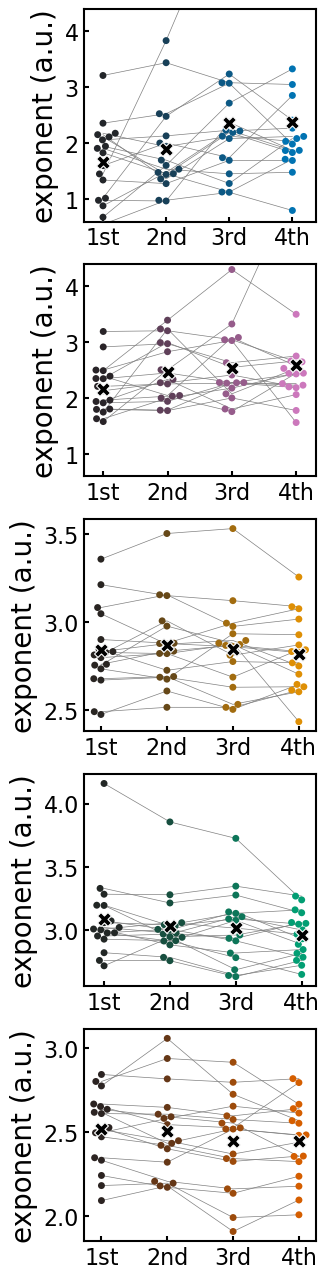

In [67]:
import seaborn
ColStage = [seaborn.color_palette("colorblind")[0], seaborn.color_palette("colorblind")[4],
            seaborn.color_palette("colorblind")[1], 
        seaborn.color_palette("colorblind")[2],seaborn.color_palette("colorblind")[3]]

titles =  ['1st','2nd', '3rd','4th']
fig = plt.figure(figsize=(3, 16))  

All_stages = [WKq,N1q,N2q,N3q,RMq]
alphas = np.linspace(0.1, 1, 5)
weights = np.arange(1, 6)
i=0
for x in All_stages:

    ax = fig.add_subplot(5,1, i+1)

    s1za = np.nanmean(x[0,:,:],1)
    s1za[np.isnan(s1za)] = np.nanmean(s1za)

    s2za = np.nanmean(x[1,:,:],1)
    s2za[np.isnan(s2za)] = np.nanmean(s2za)

    s3za = np.nanmean(x[2,:,:],1)
    s3za[np.isnan(s3za)] = np.nanmean(s3za)

    s4za = np.nanmean(x[3,:,:],1)
    s4za[np.isnan(s4za)] = np.nanmean(s4za)

    
    array_list = [s1za, s2za,s3za, s4za]
    
    Col = ColStage[0]
    
    
    # Plotting
    ax = seaborn.swarmplot(data= array_list, color = ColStage[i])
    plt.ylabel(titles, fontsize = 20)
    ax.set_xticklabels(titles, fontsize = 20)
    seaborn.scatterplot(x=[0,1,2,3], y=[np.nanmean(array_list[0]),np.nanmean(array_list[1]),np.nanmean(array_list[2]),
                                          np.nanmean(array_list[3])]
                                          , marker='X', color='black', s=100, zorder=4, legend=False);
    plt.plot([array_list[0], array_list[1], array_list[2], array_list[3]], color = 'grey', linewidth = 0.5);
   
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('exponent (a.u.)', fontsize=20)
    
    if i == 1 or i == 0:
        plt.ylim([0.6, 4.4])

    ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['top'].set_linewidth(1.5)
    
    i=i+1
plt.savefig("/home/b1044271/Columbia/Plots/NOV23/EEG_sleep_cycles_30s.svg", dpi = 600)

#  PERFORM STATS

In [57]:
#N1
from pandas.plotting import table 
N1q[:,:,2] = 
lis1 = [np.nanmean(N1q[0,:,:],1), np.nanmean(N1q[1,:,:],1), np.nanmean(N1q[2,:,:],1), np.nanmean(N1q[3,:,:],1)]

data = pd.DataFrame(np.transpose(lis1))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

print(friedman_result,W)

FriedmanchisquareResult(statistic=8.647058823529392, pvalue=0.0343708073503919) 0.16955017301038022


In [58]:
# KNEE - STATS
lis1 = [np.nanmean(N2q[0,:,:],1), np.nanmean(N2q[1,:,:],1), np.nanmean(N2q[2,:,:],1), np.nanmean(N2q[3,:,:],1)]

data = pd.DataFrame(np.transpose(lis1))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

print(friedman_result,W)

FriedmanchisquareResult(statistic=2.2941176470588402, pvalue=0.5136487462354025) 0.044982698961938045


In [59]:
# KNEE - STATS
lis1 = [np.nanmean(N3q[0,:,:],1), np.nanmean(N3q[1,:,:],1), np.nanmean(N3q[2,:,:],1), np.nanmean(N3q[3,:,:],1)]

data = pd.DataFrame(np.transpose(lis1))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

print(friedman_result,W)

FriedmanchisquareResult(statistic=6.035294117647084, pvalue=0.10990565877943162) 0.11833910034602124


In [60]:
# KNEE - STATS
lis1 = [np.nanmean(RMq[0,:,:],1), np.nanmean(RMq[1,:,:],1), np.nanmean(RMq[2,:,:],1), np.nanmean(RMq[3,:,:],1)]

data = pd.DataFrame(np.transpose(lis1))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

print(friedman_result,W)

FriedmanchisquareResult(statistic=13.305882352941182, pvalue=0.004019715849325853) 0.26089965397923887


In [61]:
# KNEE - STATS
lis1 = [np.nanmean(WKq[0,:,:],1), np.nanmean(WKq[1,:,:],1), np.nanmean(WKq[2,:,:],1), np.nanmean(WKq[3,:,:],1)]

data = pd.DataFrame(np.transpose(lis1))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

print(friedman_result,W)

FriedmanchisquareResult(statistic=3.211764705882331, pvalue=0.36011335379793075) 0.06297577854671237


# KNEE?

In [435]:
# calculate knee frequency

# KNEE freqs
from fooof.utils.params import compute_knee_frequency

knees = compute_knee_frequency(Knee_k, Slope_k)  



In [441]:
# Use the appropriate model
N1k = knees[0,:,:]
N2k = knees[1,:,:]
N3k = knees[2,:,:]
RMk = knees[4,:,:]
WKk = knees[3,:,:]

# get the same number of epochs for all subjects
#################################################
N1nn=np.zeros(17)*np.nan
N2nn=np.zeros(17)*np.nan
N3nn=np.zeros(17)*np.nan
RMnn=np.zeros(17)*np.nan
WKnn=np.zeros(17)*np.nan

for i in np.arange(17):
    x1 = N1k[i,]
    N1nn[i] = len(x1[~np.isnan(x1)])
    x2 = N2k[i,]
    N2nn[i] = len(x2[~np.isnan(x2)])
    x3 = N3k[i,]
    N3nn[i] = len(x3[~np.isnan(x3)])
    x4 = RMk[i,]
    RMnn[i] = len(x4[~np.isnan(x4)])
    x5 = WKk[i,]
    WKnn[i] = len(x5[~np.isnan(x5)])
    
mN1 = min(N1nn)
mN2 = min(N2nn)
mN3 = min(N3nn)
mRM = min(RMnn)
mWK = min(WKnn)

N1z2 = np.delete(N1k, slice(int(mN1+1),5000), 1)  # delete second row of A
N2z2 = np.delete(N2k, slice(int(mN2+1),5000), 1)  # delete second row of A
N3z2 = np.delete(N3k, slice(int(mN3+1),5000), 1)  # delete second row of A
RMz2 = np.delete(RMk, slice(int(mRM+1),5000), 1)  # delete second row of A
WKz2 = np.delete(WKk, slice(int(mWK+1),5000), 1)  # delete second row of A


In [442]:
# Plot without correction
N1za = np.nanmean(N1z2,0)
N1zb = N1za[~np.isnan(N1za)]

N2za = np.nanmean(N2z2,0)
N2zb = N2za[~np.isnan(N2za)]

N3za = np.nanmean(N3z2,0)
N3zb = N3za[~np.isnan(N3za)]

RMza = np.nanmean(RMz2,0)
RMzb = RMza[~np.isnan(RMza)]

WKza = np.nanmean(WKz2,0)
WKzb = WKza[~np.isnan(WKza)]

#find line of best fit
a1, b1 = np.polyfit(np.arange(len(N1zb)), N1zb, 1)
a2, b2 = np.polyfit(np.arange(len(N2zb)), N2zb, 1)
a3, b3 = np.polyfit(np.arange(len(N3zb)), N3zb, 1)
a4, b4 = np.polyfit(np.arange(len(RMzb)), RMzb, 1)
a5, b5 = np.polyfit(np.arange(len(WKzb)), WKzb, 1)

plt.figure(figsize=(20, 10), dpi=600)
# Plotting
plt.scatter(np.arange(len(N1zb)),N1zb, color = 'grey', s =25)
plt.scatter(np.arange(len(N2zb)),N2zb, color = 'orange', s =25)
plt.scatter(np.arange(len(N3zb)),N3zb, color = 'green', s =25)
plt.scatter(np.arange(len(RMzb)),RMzb, color = 'r', s =25)
plt.scatter(np.arange(len(WKzb)),WKzb, color = 'b', s =25)

plt.plot(np.arange(len(WKzb)), a5*np.arange(len(WKzb))+b5,color = 'b',label='W', linewidth = 5)
plt.plot(np.arange(len(N1zb)), a1*np.arange(len(N1zb))+b1,color = 'grey',label='N1', linewidth = 5)
plt.plot(np.arange(len(N2zb)), a2*np.arange(len(N2zb))+b2,color = 'orange',label='N2', linewidth = 5)
plt.plot(np.arange(len(N3zb)), a3*np.arange(len(N3zb))+b3,color = 'green',label='N3', linewidth = 5)
plt.plot(np.arange(len(RMzb)), a4*np.arange(len(RMzb))+b4,color = 'r',label='REM', linewidth = 5)

plt.legend(fontsize=40)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.ylabel('exponent',fontsize=40)
plt.xlabel('epoch number',fontsize=40)
plt.title('Knee through the night - non-normalized - Min epochs / stage', fontsize = 40)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(3.5)
ax.spines['left'].set_linewidth(3.5)


In [456]:
#zscore
N1z3=np.zeros([17,int(mN1)+1])*np.nan
N2z3=np.zeros([17,int(mN2)+1])*np.nan
N3z3=np.zeros([17,int(mN3)+1])*np.nan
RMz3=np.zeros([17,int(mRM)+1])*np.nan
WKz3=np.zeros([17,int(mWK)+1])*np.nan 

for i in np.arange(17):
    N1z3[i, 0:int(mN1)+1] = stats.zscore(N1z2[i,], nan_policy='omit')
    N2z3[i, 0:int(mN2)+1] = stats.zscore(N2z2[i,], nan_policy='omit')
    N3z3[i, 0:int(mN3)+1] = stats.zscore(N3z2[i,], nan_policy='omit')
    RMz3[i, 0:int(mRM)+1] = stats.zscore(RMz2[i,], nan_policy='omit')
    WKz3[i, 0:int(mWK)+1] = stats.zscore(WKz2[i,], nan_policy='omit')

In [458]:
N3z3

array([[ 0.68424424, -0.74306934,  0.49097604, ...,  1.49762437,
         0.13671064, -0.64093223],
       [-0.68152466, -0.47512362,         nan, ...,  1.77638934,
         2.3355988 , -0.57780807],
       [ 0.558136  , -0.01815354, -0.1576188 , ..., -0.55695393,
                nan, -0.77479308],
       ...,
       [-0.12151015,  2.94893931,  2.07403147, ...,  0.66173181,
         0.83706087, -0.34722943],
       [ 0.44056507,  1.97654277,  0.66891082, ..., -0.52212057,
        -1.21699312, -0.75922211],
       [ 1.81191946,  2.22953399, -0.16704327, ...,  0.9927941 ,
         1.43255721,  2.38443621]])

In [459]:
N1za = np.nanmean(N1z3,0)
N1zb = N1za[~np.isnan(N1za)]

N2za = np.nanmean(N2z3,0)
N2zb = N2za[~np.isnan(N2za)]

N3za = np.nanmean(N3z3,0)
N3zb = N3za[~np.isnan(N3za)]

RMza = np.nanmean(RMz3,0)
RMzb = RMza[~np.isnan(RMza)]

WKza = np.nanmean(WKz3,0)
WKzb = WKza[~np.isnan(WKza)]




#find line of best fit
a1, b1 = np.polyfit(np.arange(len(N1zb)), N1zb, 1)
a2, b2 = np.polyfit(np.arange(len(N2zb)), N2zb, 1)
a3, b3 = np.polyfit(np.arange(len(N3zb)), N3zb, 1)
a4, b4 = np.polyfit(np.arange(len(RMzb)), RMzb, 1)
a5, b5 = np.polyfit(np.arange(len(WKzb)), WKzb, 1)

plt.figure(figsize=(20, 10), dpi=600)
# Plotting
plt.scatter(np.arange(len(N1zb)),N1zb, color = 'grey', s =45)
plt.scatter(np.arange(len(N2zb)),N2zb, color = 'orange', s =45)
plt.scatter(np.arange(len(N3zb)),N3zb, color = 'green', s =45)
plt.scatter(np.arange(len(RMzb)),RMzb, color = 'r', s =45)
plt.scatter(np.arange(len(WKzb)),WKzb, color = 'b', s =45)

plt.plot(np.arange(len(WKzb)), a5*np.arange(len(WKzb))+b5,color = 'b',label='W', linewidth = 5)
plt.plot(np.arange(len(N1zb)), a1*np.arange(len(N1zb))+b1,color = 'grey',label='N1', linewidth = 5)
plt.plot(np.arange(len(N2zb)), a2*np.arange(len(N2zb))+b2,color = 'orange',label='N2', linewidth = 5)
plt.plot(np.arange(len(N3zb)), a3*np.arange(len(N3zb))+b3,color = 'green',label='N3', linewidth = 5)
plt.plot(np.arange(len(RMzb)), a4*np.arange(len(RMzb))+b4,color = 'r',label='REM', linewidth = 5)

plt.legend(fontsize=40)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.ylabel('exponent (z-score)',fontsize=40)
plt.xlabel('epoch number',fontsize=40)
plt.title('Exponent through the night - normalized - Min epochs / stage', fontsize = 40)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(3.5)
ax.spines['left'].set_linewidth(3.5)

#plt.savefig("/home/b1044271/Columbia/Plots/NOV23/EEG_exponent_thru_night_30s_FIXED.svg", dpi = 600)

# CYCLES
## Divide night into 4 quartiles

In [483]:
q1=np.zeros([17,500])*np.nan
q2=np.zeros([17,500])*np.nan
q3=np.zeros([17,500])*np.nan
q4=np.zeros([17,500])*np.nan

for i in np.arange(17):
    
    X = Slope_k_fullnight[i,~np.isnan(Slope_k_fullnight[i,:])]
    quadX = round(len(X)/4)
    q1[i,0:quadX] = X[0:quadX]
    q2[i,0:quadX] = X[quadX:quadX*2]
    q3[i,0:quadX] = X[quadX*2:quadX*3]
    q4[i,0:len(X[quadX*3:quadX*4])] = X[quadX*3:quadX*4]

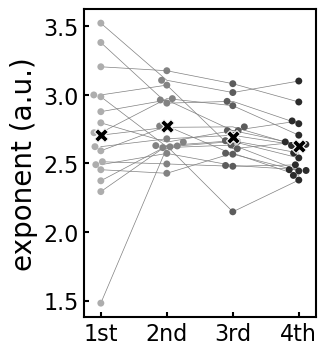

In [488]:
ColStage = [seaborn.color_palette("Greys")[2], seaborn.color_palette("Greys")[3],
        seaborn.color_palette("Greys")[4],seaborn.color_palette("Greys")[5]]

titles =  ['1st','2nd', '3rd','4th']

fig = plt.figure(figsize=(3, 4))  


s1za = np.nanmean(q1,1)
s1za[np.isnan(s1za)] = np.nanmean(s1za)

s2za = np.nanmean(q2,1)
s2za[np.isnan(s2za)] = np.nanmean(s2za)

s3za = np.nanmean(q3,1)
s3za[np.isnan(s3za)] = np.nanmean(s3za)

s4za = np.nanmean(q4,1)
s4za[np.isnan(s4za)] = np.nanmean(s4za)

    
array_list = [s1za, s2za,s3za, s4za]
    
Col = ColStage[0]
    
    
# Plotting
ax = seaborn.swarmplot(data= array_list, palette = ColStage)
plt.ylabel(titles, fontsize = 20)
ax.set_xticklabels(titles, fontsize = 20)
seaborn.scatterplot(x=[0,1,2,3], y=[np.nanmean(array_list[0]),np.nanmean(array_list[1]),np.nanmean(array_list[2]),
                                          np.nanmean(array_list[3])]
                                          , marker='X', color='black', s=100, zorder=4, legend=False);
plt.plot([array_list[0], array_list[1], array_list[2], array_list[3]], color = 'grey', linewidth = 0.5);
   
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('exponent (a.u.)', fontsize=20)
    
#plt.ylim([0, 7])

ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
    

#plt.savefig("/home/b1044271/Columbia/Plots/NOV23/EEG_sleep_cycles_30s.svg", dpi = 600)